In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
from argparse import ArgumentParser
from cmsjson import CMSJson
from pdb import set_trace
import os
from glob import glob
import pandas as pd
import json
from pprint import pprint
import matplotlib.pyplot as plt

from features import *
from sklearn.externals import joblib
import xgboost as xgb
#from datasets import pre_process_data
import datasets

lxplus073.cern.ch
Welcome to JupyROOT 6.12/07


Seeding
==

In [3]:
datasets.tag = '2018Nov01'
datasets.posix = '2018Nov01'

In [4]:
biased_features, additional = get_features('displaced_improvedfullseeding')
unbiased_features, additional = get_features('improvedfullseeding')

In [5]:
cmssw_feats = [
    'preid_trk_pt',
    'preid_trk_eta',
    'preid_trk_phi',
    'preid_trk_p',
    'preid_trk_nhits',
    'preid_trk_high_quality',
    'preid_trk_chi2red',
    'preid_rho',
    'preid_ktf_ecal_cluster_e',
    'preid_ktf_ecal_cluster_deta',
    'preid_ktf_ecal_cluster_dphi',
    'preid_ktf_ecal_cluster_e3x3',
    'preid_ktf_ecal_cluster_e5x5',
    'preid_ktf_ecal_cluster_covEtaEta',
    'preid_ktf_ecal_cluster_covEtaPhi',
    'preid_ktf_ecal_cluster_covPhiPhi',
    'preid_ktf_ecal_cluster_r9',
    'preid_ktf_ecal_cluster_circularity',
    'preid_ktf_hcal_cluster_e',
    'preid_ktf_hcal_cluster_deta',
    'preid_ktf_hcal_cluster_dphi',
    'preid_gsf_dpt',
    'preid_trk_gsf_chiratio',
    'preid_gsf_chi2red',
    'preid_trk_dxy_sig',
]

In [6]:
biased_model = joblib.load(  'models/2018Nov01/bdt_bo_displaced_improvedfullseeding_noweight/model_18.pkl')
unbiased_model = joblib.load('models/2018Nov01/bdt_bo_improvedfullseeding/model_24.pkl')

def _monkey_patch():
    return model._Booster

for model in [biased_model, unbiased_model]:
    if isinstance(model.booster, basestring):
        model.booster = _monkey_patch

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
feats = set(biased_features+unbiased_features+labeling+['preid_bdtout1', 'preid_bdtout2', 'run','lumi','evt']+cmssw_feats)
datasets.input_files['test'] = ['/afs/cern.ch/work/m/mverzett/RK102v2/src/LowPtElectrons/LowPtElectrons/run/bugfix_test.root']
data = datasets.pre_process_data('test', list(feats), False)

getting files: 
/afs/cern.ch/work/m/mverzett/RK102v2/src/LowPtElectrons/LowPtElectrons/run/bugfix_test.root


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
biased_out = biased_model.predict_proba(data[biased_features].values)[:,1]
biased_out[np.isnan(biased_out)] = -999 #happens rarely, but happens

unbiased_out = unbiased_model.predict_proba(data[unbiased_features].values)[:,1]
unbiased_out[np.isnan(unbiased_out)] = -999 #happens rarely, but happens

cmssw_biased_out = biased_model.predict_proba(data[cmssw_feats].values)[:,1]
cmssw_biased_out[np.isnan(cmssw_biased_out)] = -999 #happens rarely, but happens

cmssw_unbiased_out = unbiased_model.predict_proba(data[cmssw_feats[:-1]].values)[:,1]
cmssw_unbiased_out[np.isnan(cmssw_unbiased_out)] = -999 #happens rarely, but happens


In [9]:
biased_features

['trk_pt',
 'trk_eta',
 'trk_phi',
 'trk_p',
 'trk_nhits',
 'trk_high_purity',
 'trk_chi2red',
 'rho',
 'ktf_ecal_cluster_e',
 'ktf_ecal_cluster_deta',
 'ktf_ecal_cluster_dphi',
 'ktf_ecal_cluster_e3x3',
 'ktf_ecal_cluster_e5x5',
 'ktf_ecal_cluster_covEtaEta',
 'ktf_ecal_cluster_covEtaPhi',
 'ktf_ecal_cluster_covPhiPhi',
 'ktf_ecal_cluster_r9',
 'ktf_ecal_cluster_circularity_',
 'ktf_hcal_cluster_e',
 'ktf_hcal_cluster_deta',
 'ktf_hcal_cluster_dphi',
 'preid_gsf_dpt',
 'preid_trk_gsf_chiratio',
 'preid_gsf_chi2red',
 'trk_dxy_sig']

In [4]:
def consistency(a1, a2, name, twod_only=False, vrange=[[-10, 10], [-10, 10]]):
    plt.figure(figsize=[8,8])
    plt.hist2d(a1, a2, bins=20, range=vrange)
    plt.title('%s 2d' % name)
    plt.show()
    if twod_only: return
    delta = a1 - a2
    rel_delta = delta/a1
    plt.figure(figsize=[8,8])
    plt.hist(delta)
    plt.title('%s delta' % name)
    plt.show()
    plt.figure(figsize=[8,8])
    plt.hist(rel_delta)
    plt.title('%s relative delta' % name)
    plt.show()


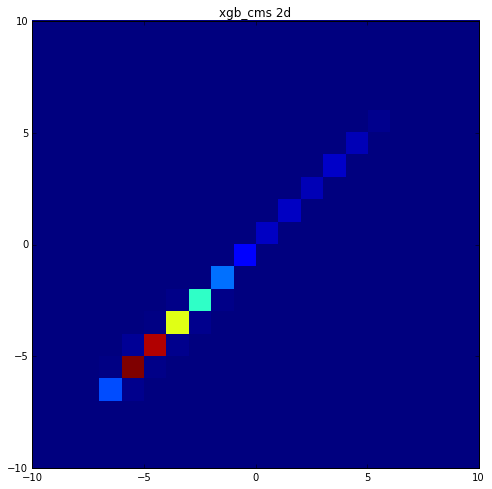

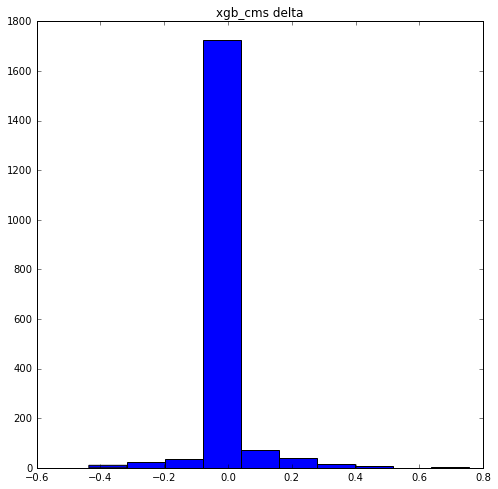

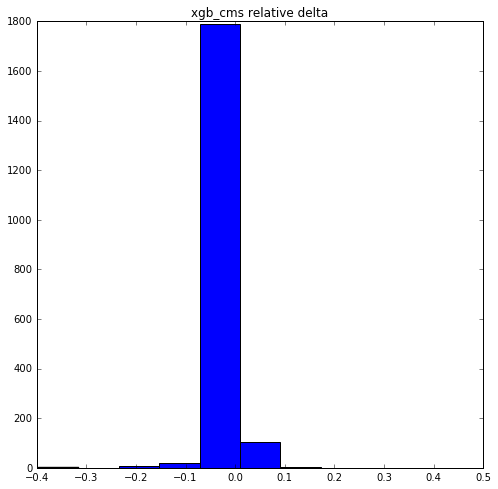

In [24]:
consistency(biased_out, data.preid_bdtout2, 'xgb_cms')

In [ ]:
consistency(cmssw_biased_out, data.preid_bdtout2, 'xgbcms_cms')

In [ ]:
consistency(biased_out, cmssw_biased_out, 'xgb_xgbcms')

In [ ]:
plt.figure(figsize=[8,8])
plt.hist(biased_out, label='xgb', range=[-10, 10], bins=20, histtype='step')
plt.hist(data.preid_bdtout2, label='cmssw', range=[-10, 10], bins=20, histtype='step')
plt.hist(cmssw_biased_out, label='xgb_cmssw', range=[-10, 10], bins=20, histtype='step')
plt.legend(loc='best')
plt.show()

In [13]:
import itertools
import scipy

In [21]:
for im, ic in itertools.izip_longest(biased_features, cmssw_feats, fillvalue='--'):
    corr, _ = scipy.stats.pearsonr(data[im], data[ic])
    print im, ' - ', ic, corr

trk_pt  -  preid_trk_pt 1.0
trk_eta  -  preid_trk_eta 1.0
trk_phi  -  preid_trk_phi 1.0
trk_p  -  preid_trk_p 1.0
trk_nhits  -  preid_trk_nhits 0.999999975729689
trk_high_purity  -  preid_trk_high_quality nan
trk_chi2red  -  preid_trk_chi2red 1.0
rho  -  preid_rho 1.0
ktf_ecal_cluster_e  -  preid_ktf_ecal_cluster_e 1.0
ktf_ecal_cluster_deta  -  preid_ktf_ecal_cluster_deta 1.0
ktf_ecal_cluster_dphi  -  preid_ktf_ecal_cluster_dphi -0.03857561664564001
ktf_ecal_cluster_e3x3  -  preid_ktf_ecal_cluster_e3x3 1.0
ktf_ecal_cluster_e5x5  -  preid_ktf_ecal_cluster_e5x5 1.0
ktf_ecal_cluster_covEtaEta  -  preid_ktf_ecal_cluster_covEtaEta 1.0
ktf_ecal_cluster_covEtaPhi  -  preid_ktf_ecal_cluster_covEtaPhi 1.0
ktf_ecal_cluster_covPhiPhi  -  preid_ktf_ecal_cluster_covPhiPhi 1.0
ktf_ecal_cluster_r9  -  preid_ktf_ecal_cluster_r9 1.0
ktf_ecal_cluster_circularity_  -  preid_ktf_ecal_cluster_circularity 1.0
ktf_hcal_cluster_e  -  preid_ktf_hcal_cluster_e 1.0
ktf_hcal_cluster_deta  -  preid_ktf_hcal_cluste

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scipy/1.1.0/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [ ]:
consistency(data['trk_dxy_sig'], data['preid_trk_dxy_sig'], '%s__%s' % (im, ic), True, [[-5,5],[-5,5]])

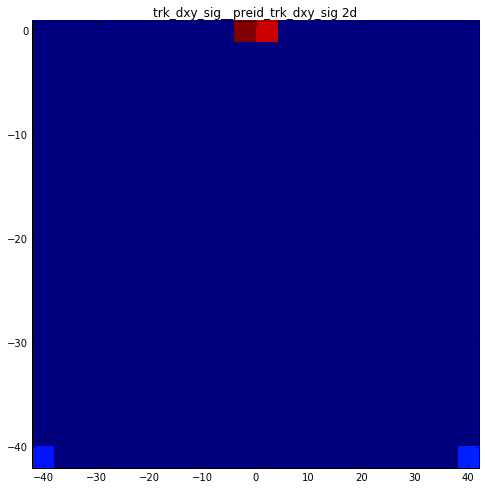

In [22]:
consistency(data.ktf_ecal_cluster_dphi, data.preid_ktf_ecal_cluster_dphi, '%s__%s' % (im, ic), True, None)

In [ ]:
aa/bb

In [ ]:
consistency(data['ktf_ecal_cluster_deta'], data['preid_ktf_ecal_cluster_deta'], '%s__%s' % (im, ic), True, None) #[[-1,1],[-1,1]])

In [ ]:
consistency(data['ktf_ecal_cluster_dphi'], data['preid_ktf_ecal_cluster_dphi'], '%s__%s' % (im, ic), True, None)

In [ ]:
consistency(data['ktf_ecal_cluster_r9'], data['preid_ktf_ecal_cluster_r9'], '%s__%s' % (im, ic), True, [[0,2],[0,2]])


ktf_hcal_cluster_deta  -  preid_ktf_hcal_cluster_deta 0.9437973
ktf_hcal_cluster_dphi  -  preid_ktf_hcal_cluster_dphi 0.03227410523313402

In [ ]:
consistency(data['ktf_hcal_cluster_deta'], data['preid_ktf_hcal_cluster_deta'], '%s__%s' % (im, ic), True, [[-1,1],[-1,1]])

In [ ]:
(data.preid_ktf_ecal_cluster_deta[data.ktf_ecal_cluster_deta < -40] == -1).all()


In [ ]:
mask = (data.ktf_ecal_cluster_deta > -40)

In [ ]:
((data.ktf_ecal_cluster_e[mask] - data.preid_ktf_ecal_cluster_e[mask])).max()


In [ ]:
consistency(data['ktf_ecal_cluster_e'][mask], data['preid_ktf_ecal_cluster_e'][mask], '%s__%s', True, [[0,20],[0,20]])

In [ ]:
mask2 = np.abs(data['ktf_ecal_cluster_e'][mask] - data['preid_ktf_ecal_cluster_e'][mask]) > 0.2

In [ ]:
consistency(data['ktf_ecal_cluster_deta'][mask][mask2], data['preid_ktf_ecal_cluster_deta'][mask][mask2], '%s__%s' % (im, ic), True, None) #[[-1,1],[-1,1]])

In [ ]:
np.abs(data['ktf_ecal_cluster_deta'][mask][mask2] - data['preid_ktf_ecal_cluster_deta'][mask][mask2]).max()

In [ ]:
mask2 = np.abs(data['ktf_ecal_cluster_e'] - data['preid_ktf_ecal_cluster_e']) > 0.2

In [ ]:
fmask = (mask & mask2)

In [ ]:
np.abs(data['ktf_ecal_cluster_e'][fmask] - data['preid_ktf_ecal_cluster_e'][fmask]).min()

In [ ]:
data[['run','lumi','evt']][fmask].to_csv('pick_electrons.list', header=False, index=False)

In [ ]:
import uproot

In [ ]:
infile = uproot.open('/afs/cern.ch/work/m/mverzett/RK10_2/src/LowPtElectrons/LowPtElectrons/run/full_test.root')
raw = pd.DataFrame(infile['features/tree'].arrays(['run','lumi','evt','ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e','ktf_ecal_cluster_deta', 'preid_ktf_ecal_cluster_deta']))

In [ ]:
raw[raw.evt == 447755850][['ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e']]

In [ ]:
infile2 = uproot.open('/afs/cern.ch/work/m/mverzett/RK10_2/src/LowPtElectrons/LowPtElectrons/run/track_features.root')
raw2 = pd.DataFrame(infile2['features/tree'].arrays(['run','lumi','evt','ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e','ktf_ecal_cluster_deta', 'preid_ktf_ecal_cluster_deta']))

In [ ]:
raw2[raw2.evt == 447755850][['ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e']]

In [ ]:
for im, ic in itertools.izip_longest(biased_features, cmssw_feats, fillvalue='--'):
    corr, _ = scipy.stats.pearsonr(data[im], data[ic])
    print im, ' - ', ic, corr

In [ ]:
bad = data['trk_nhits'] != data['preid_trk_nhits']
data['trk_nhits'][bad], data['preid_trk_nhits'][bad]

In [ ]:
bad.any()

MVA ID
==

In [5]:
mva_feats, additional = get_features('mva_id')

In [6]:
cmssw_mva_feats = [
    'eid_trk_p',
    'eid_trk_nhits',
   'eid_trk_chi2red',
   'eid_gsf_nhits',
   'eid_gsf_chi2red',
   'eid_sc_E',
   'eid_sc_eta',
   'eid_sc_etaWidth',
   'eid_sc_phiWidth',
   'eid_match_seed_dEta',
   'eid_match_eclu_EoverP',
   'eid_match_SC_EoverP',
   'eid_match_SC_dEta',
   'eid_match_SC_dPhi',
   'eid_shape_full5x5_sigmaIetaIeta',
   'eid_shape_full5x5_sigmaIphiIphi',
   'eid_shape_full5x5_HoverE',
   'eid_shape_full5x5_r9',
   'eid_shape_full5x5_circularity' ,
   'eid_rho' ,
   'eid_brem_frac' ,
   'eid_ele_pt' ,
]

In [7]:
feats = set(mva_feats+additional+cmssw_mva_feats+labeling+['ele_lowPtMva','run','lumi','evt'])
datasets.input_files['test'] = ['/afs/cern.ch/work/m/mverzett/RK102v2/src/LowPtElectrons/LowPtElectrons/run/test.root']
data = datasets.pre_process_data('test', list(feats), False)



getting files: 
/afs/cern.ch/work/m/mverzett/RK102v2/src/LowPtElectrons/LowPtElectrons/run/test.root


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
id_model = joblib.load('models/2018Oct05/bdt_bo_mva_id/model_53.pkl')
id_model.booster = lambda : id_model._Booster

In [11]:
mva_id_out = id_model.predict_proba(data[mva_feats].values)[:,1]
#biased_out[np.isnan(biased_out)] = -999 #happens rarely, but happens
print np.isnan(mva_id_out).any()

False


In [12]:
mask = data.ele_pt > 1

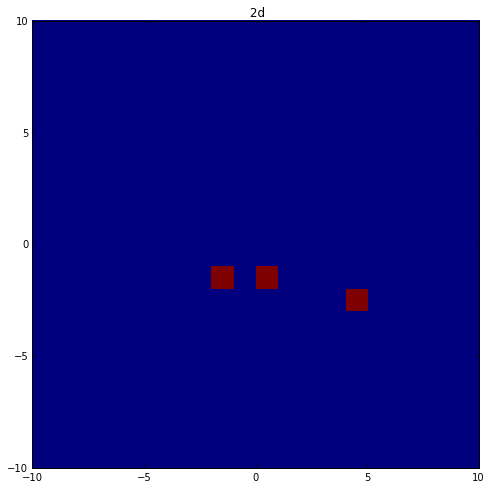

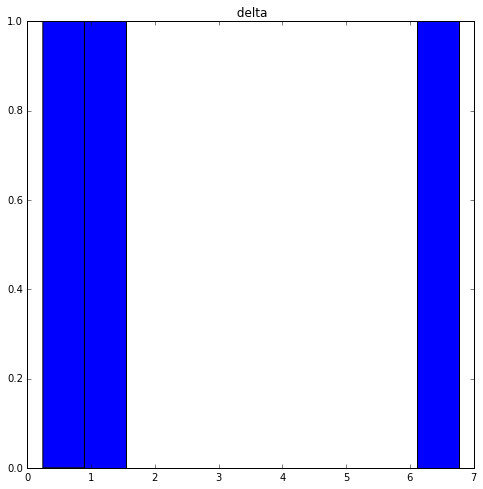

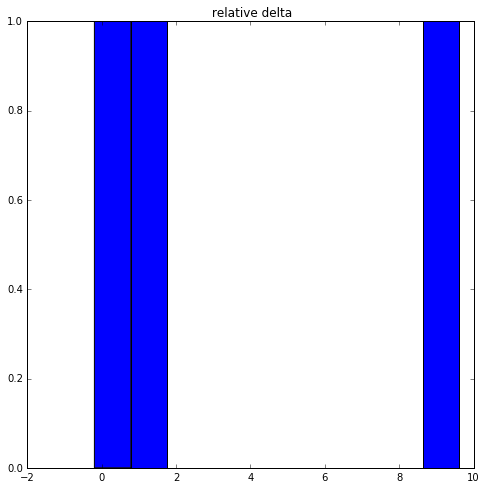

In [13]:
consistency(mva_id_out[mask], data.ele_lowPtMva[mask], "", twod_only=False, vrange=[[-10, 10], [-10, 10]])

In [14]:
mask.sum()

3

In [15]:
mva_id_out[mask].min(), mva_id_out[mask].max()

(-1.268836, 4.744253)

In [16]:
data.ele_lowPtMva[mask].min(), data.ele_lowPtMva[mask].max()

(-2.0233195, -1.0552367)

In [17]:
data['ktf_ecal_cluster_dphi'].max(), data['preid_ktf_ecal_cluster_dphi'].max()

KeyError: 'ktf_ecal_cluster_dphi'

In [14]:
for im, ic in itertools.izip_longest(mva_feats, cmssw_mva_feats, fillvalue='--'):
    corr, _ = scipy.stats.pearsonr(data[mask][im], data[mask][ic])
    print im, ' - ', ic, corr

rho  -  eid_trk_p -0.37192464
ele_pt  -  eid_trk_nhits -0.9291431
sc_eta  -  eid_trk_chi2red 0.910046
shape_full5x5_sigmaIetaIeta  -  eid_gsf_nhits -0.55496854
shape_full5x5_sigmaIphiIphi  -  eid_gsf_chi2red 0.96367913
shape_full5x5_circularity  -  eid_sc_E 0.04166129
shape_full5x5_r9  -  eid_sc_eta 0.1610032
sc_etaWidth  -  eid_sc_etaWidth 1.0
sc_phiWidth  -  eid_sc_phiWidth 1.0
shape_full5x5_HoverE  -  eid_match_seed_dEta 0.30974886
trk_nhits  -  eid_match_eclu_EoverP -0.24298141954835348
trk_chi2red  -  eid_match_SC_EoverP -0.28876495
gsf_chi2red  -  eid_match_SC_dEta 0.34571746
brem_frac  -  eid_match_SC_dPhi -0.051743917
gsf_nhits  -  eid_shape_full5x5_sigmaIetaIeta -0.5549685126075781
match_SC_EoverP  -  eid_shape_full5x5_sigmaIphiIphi 0.5444921
match_eclu_EoverP  -  eid_shape_full5x5_HoverE -0.7185807
match_SC_dEta  -  eid_shape_full5x5_r9 -0.9978552
match_SC_dPhi  -  eid_shape_full5x5_circularity 0.6418875
match_seed_dEta  -  eid_rho nan
sc_E  -  eid_brem_frac 0.5675415
trk_p  

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scipy/1.1.0/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den
